In [13]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from ews_analysis import hopf_helper as hh
from ews_analysis.saddlenode_ews import *
from ews_helper import get_ews, itoEulerMaruyama


In [14]:
## Data plot func

def plot(tt, xx, results, epsilon, a, show_plot=True, stream_dim=5):
    # plt.plot(sol.y[0, :], sol.y[1, :])
    fig, axs = plt.subplots(3)
    # Plot solutions to ode's
    sol_plot = axs[0].plot(tt, results[:, 1], color='b', label='x(t)')
    axs[0].plot(tt, results[:, 1], color='orange', label='r(t)')
    axs[0].set_xlabel('time')
    axs[0].set_ylabel(r'x&r', rotation=0)
    axs[0].set_xlim([0, 3])
    axs[0].set_ylim(
        [
            min(results[:,1]), 
            max(results[:,1])+5
    ])
    axs[0].grid()
    
    box = axs[0].get_position()
    axs[0].set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # axs[0].legend()


    # Plot phase space of derivatives
    X_dot, Y_dot = dSdt(tt,[xx,xx], epsilon, a)

    phase_space = axs[1].plot(xx, X_dot, color='b', label='x')
    axs[1].plot(xx, Y_dot, color='orange', label='y')
    scat = axs[1].scatter([], [], c='black')

    axs[1].grid()
    axs[1].set_xlabel('x')
    axs[1].set_ylabel(r'$\dot{x}$', rotation=0)
    axs[1].set_ylim([-200,2500])
    axs[1].set_xlim([min(xx),max(xx)])
    
    box = axs[1].get_position()
    axs[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # axs[1].legend()

    # Streamlines of X - Y space 
    # w = stream_dim
    # Y, X = np.mgrid[-w:w:1000j, -w:w:1000j]
    # U, V = dSdt(tt,[X,Y], epsilon, a)
    # stream = axs[2].streamplot(X, Y, U, V, density = 1)
    # axs[2].set_ylim([-1*w, w])
    # axs[2].set_xlim([-1*w, w])

    if show_plot:
        plt.show()

    return fig, axs


In [15]:
## Model 

def dSdt(t, S, epsilon, a):
    x, y = S
    try:
        shaper = np.ones_like(y)
    except:
        try:
            shaper = np.ones(len(y))
        except:
            shaper = 1

    return [
        y + a*x**2 - x**3,
        epsilon * shaper
    ]


In [16]:
# Hyper-params

# r0 = 1
# x0 = 0
# y0 = 0
# epsilon = 1
# gamma = 0.0001 # noise intensity
# a = 25

"""
xdot = -1 +4x^2 + 0
"""

r0 = -0.5
x0 = 0.01
a = 4
epsilon = 0.001
gamma = 0.002 / np.sqrt(epsilon)  # noise intensity

time = tt = np.linspace(0, 10, 10000)
xx = np.linspace(1, 30, 100000)

dt = time[1] - time[0]
epsilon = epsilon / dt

In [17]:
# Compute

# sol = solve_ivp(
#     dSdt, t_span=[min(tt), max(tt)], 
#     y0=[x0, y0], t_eval=tt, args=(epsilon, a)
# )

# Euler Maruyama
results,derivatives = itoEulerMaruyama(
    model=dSdt,
    y0=[x0, r0],
    time=tt,
    noise=[gamma,0],args=(epsilon, a),save_derivative=True
)

slope,intercept,_,_,_ = linregress(tt, results[:,0])
# mu=0=intercept+slope*t iff t=-intercept/slope
t_star = tt[np.where(results[:,1] >= 0)[0][0]]

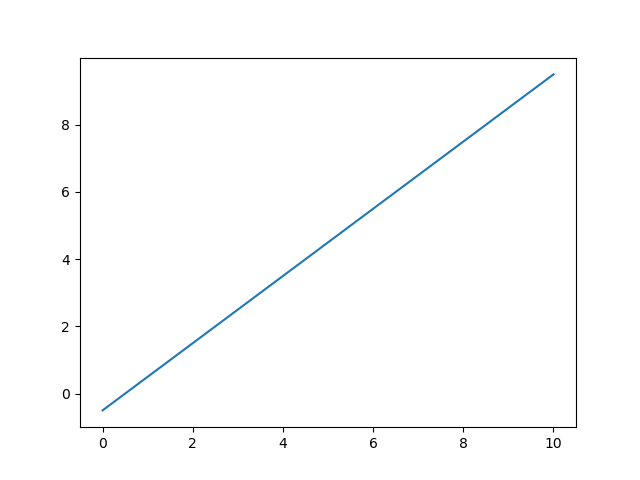

In [18]:
fig, ax = plt.subplots()
ax.plot(time,results[:,1])
plt.show()

In [19]:
time[np.where(results[:,1] >= 0)[0][0]]


0.5000500050005

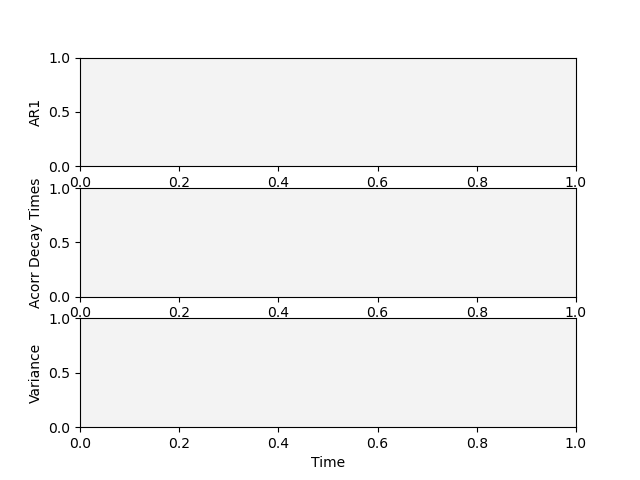

In [20]:
fig, axs = plt.subplots(3,1)
ax0, ax1, ax2 = axs
ax0.set_ylabel('AR1')
ax1.set_ylabel('Acorr Decay Times')
ax1.sharex(ax0)
ax2.set_ylabel('Variance')
ax2.sharex(ax0)
ax2.set_xlabel('Time')

for ax in axs:
    ax.set_facecolor(plt.cm.gray(.95))


In [21]:
win_size = ews_win_size = 21
offset = ews_offset = 3

start_time = np.where(time < 0.7 )[0][-1]
stop_time = np.where(time > 1.3 )[0][0]

time_win = time[start_time:stop_time]
results_win = results[start_time:stop_time, 0]

print(start_time, time[start_time+1])
print(stop_time, time[stop_time])

699 0.7000700070007001
1300 1.3001300130013


In [22]:
block_idxs, noisy_ar1s, noisy_decays, noisy_vars = get_ews(
    time_win, results_win, win_size=win_size, offset=offset
)

# Plot AR1s
axs[0].plot(time_win[block_idxs[:len(noisy_ar1s)]], noisy_ar1s, label=f'With Noise')
axs[0].axvline(
    t_star, color='k', linestyle='--', 
    alpha=0.5, label='x=0'
)

# Plot Decays
axs[1].plot(time_win[block_idxs[:len(noisy_decays)]], noisy_decays, label=f'With Noise')
axs[1].axvline(
    t_star, color='k', linestyle='--', 
    alpha=0.5, label='x=0'
)

# Plot Variance
axs[2].plot(time_win[block_idxs[:len(noisy_vars)]], noisy_vars, label=f'With Noise')
axs[2].axvline(
    t_star, color='k', linestyle='--', 
    alpha=0.5, label='x=0'
)

for ax in axs:
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.legend()
    
ttl = f'EWS For Saddle Node Bifurcation'
ttl += f'\n'+ f'window size={win_size}, offset={offset}, noise={gamma}'
fig.suptitle(ttl)

100%|██████████| 194/194 [00:00<00:00, 5332.87it/s]


Text(0.5, 0.98, 'EWS For Saddle Node Bifurcation\nwindow size=21, offset=3, noise=0.0632455532033676')

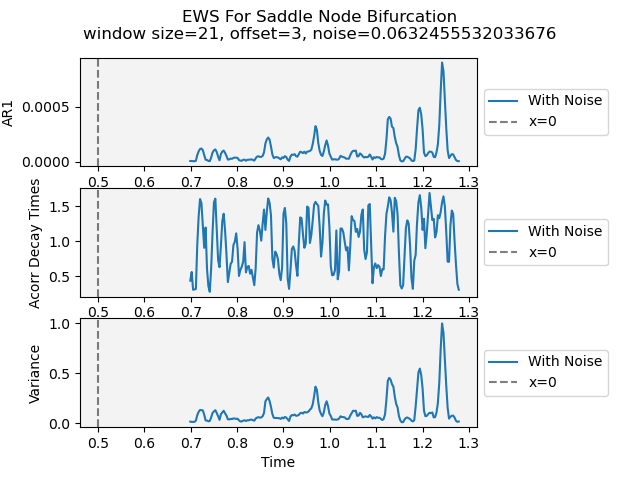

In [23]:
plt.show()

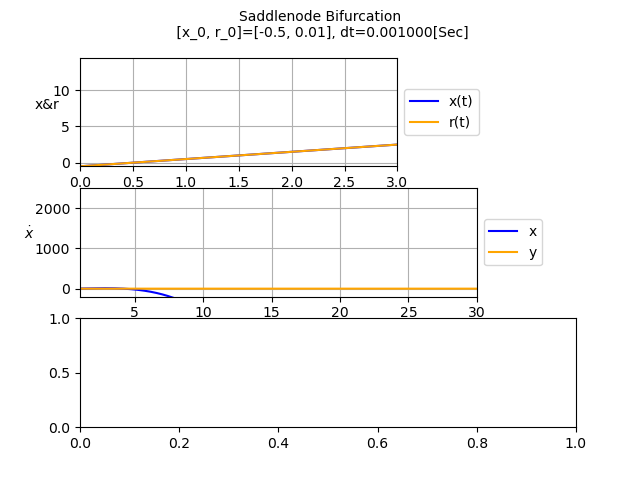

In [24]:
fig, axs = plot(tt, xx, results, epsilon, a, show_plot=False)
ttl = r"""Saddlenode Bifurcation"""
ttl = ttl + "\n" + f""" [x_0, r_0]=[{r0}, {x0}], dt={dt:2f}[Sec]"""

fig.suptitle(ttl, fontsize=10)

# axs[0].plot(
#     tt, results[:,0], color='crimson', label='Maroyama_x(t)', ls='-.'
# )

box = axs[0].get_position()
axs[0].set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
# axs[0].legend()
plt.show()
